# Python Data Science and Machine Learning Capstone Project
A program capstone provided by IBM on edx.org

## Problem:

The people of New Yorker use the 311 system to report complaints about the non-emergency problems to local authorities. Various agencies in New York are assigned these problems. The Department of Housing Preservation and Development of New York City is the agency that processes 311 complaints that are related to housing and buildings.

In the last few years, the number of 311 complaints coming to the Department of Housing Preservation and Development has increased significantly. Although these complaints are not necessarily urgent, the large volume of complaints and the sudden increase is impacting the overall efficiency of operations of the agency.

Therefore, the Department of Housing Preservation and Development has approached your organization to help them manage the large volume of 311 complaints they are receiving every year.
The agency needs answers to several questions. The answers to those questions must be supported by data and analytics.

## Datasets

311 Complaint dataset
Download link:

https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-DS0720EN-SkillsNetwork/labs/Module%201/data/311_Service_Requests_from_2010_to_Present_min.csv

Also available at:

https://data.cityofnewyork.us/Social-Services/311-Service-Requests-from-2010-to-Present/erm2-nwe9?cm_mmc=Email_Newsletter-_-Developer_Ed%2BTech-_-WW_WW-_-SkillsNetwork-Courses-IBMDeveloperSkillsNetwork-DS0720EN-SkillsNetwork-20719275-courses-edx-org&cm_mmca1=000026UJ&cm_mmca2=10006555&cm_mmca3=M12345678&cvosrc=email.Newsletter.M12345678&cvo_campaign=000026UJ&cm_mmca1=000026UJ&cm_mmca2=10006555&cm_mmca3=M12345678&cvosrc=email.Newsletter.M12345678&cvo_campaign=000026UJ

PLUTO dataset for housing
Download link:

https://www1.nyc.gov/assets/planning/download/zip/data-maps/open-data/nyc_pluto_18v1.zip?cm_mmc=Email_Newsletter-_-Developer_Ed%2BTech-_-WW_WW-_-SkillsNetwork-Courses-IBMDeveloperSkillsNetwork-DS0720EN-SkillsNetwork-20719275-courses-edx-org&cm_mmca1=000026UJ&cm_mmca2=10006555&cm_mmca3=M12345678&cvosrc=email.Newsletter.M12345678&cvo_campaign=000026UJ


## Data Cleaning

In [18]:
#POTENTIAL CHANGES
#start changing things to be functions and function calls rather than hard coding everything
nrows = 10000 #311 complaints is large, restricting Number of rows on import or it takes forever to load


print('Importing libraries...')
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LogisticRegression
print('Libraries Imported')

Importing libraries...
Libraries Imported


In [19]:
#specify data types on import using 'dtype' parameter in read_csv() instead of changing all of the datatypes after impo

print('Loading Datasets...')
print('    Loading 311 Complaints Dataset...')

file = '311_Service_Requests_from_2010_to_Present_min.csv'
columnList = ['Unique Key', 'Complaint Type', 'Location Type', 'Incident Address', 'Street Name', 'Address Type', 'City', 'Status', 'Resolution Description', 'Borough', 'Latitude', 'Longitude', 'Created Date', 'Closed Date', 'Incident Zip']
datatypesDict = {'Unique Key' : int, 'Complaint Type' : str, 'Location Type' : str, 'Incident Address': str, 'Street Name': str, 'Address Type': str, 'City': str, 'Status': str, 'Resolution Description': str, 'Borough': str, 'Latitude': float, 'Longitude': float, 'Incident Zip': str}

comp_df = pd.read_csv(file, usecols = columnList, dtype = datatypesDict, parse_dates = ['Created Date', 'Closed Date'])#, nrows = nrows)

print('    Loading New York Buildings Datasets...')

columnList = ['Borough', 'Address', 'BldgArea', 'BuiltFAR', 'CommFAR', 'FacilFAR', 'LotArea', 'LotDepth', 'NumBldgs', 'NumFloors', 'OfficeArea', 'ResArea', 'ResidFAR', 'RetailArea', 'YCoord', 'XCoord', 'Lot', 'YearBuilt', 'YearAlter1', 'ZipCode']
datatypesDict = {'Borough': str, 'Address': str , 'BldgArea': float, 'BuiltFAR': float, 'CommFAR': float, 'FacilFAR': float, 'LotArea': float, 'LotDepth': float, 'NumBldgs': int, 'NumFloors': float, 'OfficeArea': int, 'ResArea': int, 'ResidFAR': float, 'RetailArea': float, 'YCoord': float, 'XCoord': float, 'Lot': str, 'YearBuilt': int, 'YearAlter1': int, 'ZipCode': str}
fileList = ['BX_18v1.csv', 'BK_18v1.csv', 'MN_18v1.csv', 'QN_18v1.csv', 'SI_18v1.csv']
dfList = []

for file in fileList:
    dfList.append(pd.read_csv(file, usecols = columnList, dtype = datatypesDict))
buildings_df = pd.concat(objs = dfList)

print('    New York Buildings Dataset Loaded')
print('Datasets Loaded')

Loading Datasets...
    Loading 311 Complaints Dataset...
    Loading New York Buildings Datasets...
    New York Buildings Dataset Loaded
Datasets Loaded


In [20]:
print("Data Cleaning Started...")

#eliminate '.0' from the end of zipcodes left over from changing datatypes from float to string on dataset import
zipsList = comp_df['Incident Zip'].tolist()
corrZipsList = []

for value in zipsList:
    try:
        new = value.replace('.0', '').replace('nan', "NONE")
    except AttributeError:
        #a random handful of zipcodes typically don't get converted from float to object on import, here is the contingency for that
        new = str(value).replace('.0', '').replace('nan', "NONE")
    corrZipsList.append(new)
comp_df[['Incident Zip']] = corrZipsList

#same as above but with the New York Buildings Dataset
zipsList = buildings_df['ZipCode'].tolist()
corrZipsList = []
for Zip in zipsList:
    try:
        new = value.replace('.0', '').replace('nan', 'NONE')
    except AttributeError:
        new = str(value.replace('.0', '').replace('nan', 'NONE'))
        #a random handful of zipcodes typically don't get converted from float to object on import, here is the contingency for that
    corrZipsList.append(new)
buildings_df[['ZipCode']] = corrZipsList

del zipsList
del corrZipsList

#set the complaints dataset key to the unique key column
comp_df.set_index('Unique Key', inplace = True)

#combine duplicate columns
comp_df.loc[comp_df['Complaint Type'] == 'Unsanitary Condition', 'Complaint Type'] = 'UNSANITARY CONDITION'
comp_df.loc[comp_df['Complaint Type'] == 'Electric', 'Complaint Type'] = 'ELECTRIC'
comp_df.loc[comp_df['Complaint Type'] == 'Plumbing', 'Complaint Type'] = 'PLUMBING'
comp_df.loc[comp_df['Complaint Type'] == 'Appliance', 'Complaint Type'] = 'APPLIANCE'
comp_df.loc[comp_df['Complaint Type'] == 'General', 'Complaint Type'] = 'GENERAL'
comp_df.loc[comp_df['Complaint Type'] == 'Safety', 'Complaint Type'] = 'SAFETY'
comp_df.loc[comp_df['Complaint Type'] == 'Outside Building', 'Complaint Type'] = 'OUTSIDE BUILDING'
comp_df.loc[comp_df['Complaint Type'] == 'PAINT - PLASTER', 'Complaint Type'] = 'PAINT/PLASTER'

#rename 'Incident Address' to just 'Address' for better compatibility with New York buildings dataset
comp_df = comp_df.rename(columns = {'Incident Address': 'Address'})

print('Data Cleaning Completed')

Data Cleaning Started...
Data Cleaning Completed


## Questions

QUESTION: Which type of complaint should the Department of Housing Preservation and Development of New York City focus on first?

In [21]:
iterList = []
print("Complaint Type T-Table...")
for value in comp_df['Complaint Type'].unique():
    iterList.append((comp_df['Complaint Type'] == value).sum())
compCount = pd.DataFrame(data = iterList, index = comp_df['Complaint Type'].unique(), columns = ['Total'])
iterList = []
total = int(compCount.sum())
for item in compCount.index:
    iterList.append((compCount.loc[item, 'Total'] / total)*100)
compCount['Percentage of Complaints'] = iterList
del total
iterList = []
compCount.sort_values(ascending = False, inplace = True, by = 'Total')
display(compCount)

Complaint Type T-Table...


,Total,Percentage of Complaints
HEAT/HOT WATER,1261574,20.956925
HEATING,887850,14.748724
PLUMBING,711141,11.813282
PAINT/PLASTER,707695,11.756037
GENERAL CONSTRUCTION,500863,8.320200
UNSANITARY CONDITION,457142,7.593919
ELECTRIC,307311,5.104967
NONCONST,260890,4.333834
DOOR/WINDOW,205278,3.410022
WATER LEAK,193631,3.216546


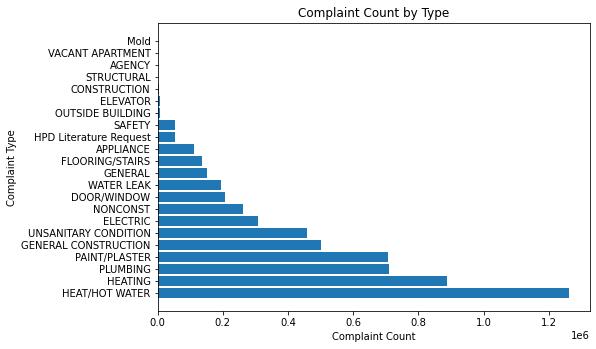

In [22]:
fig = plt.figure()
ax = fig.add_axes([0, 0, 1, 1])
ax.barh(compCount.index, compCount['Total'])
ax.set_title('Complaint Count by Type')
ax.set_ylabel('Complaint Type')
ax.set_xlabel('Complaint Count')
plt.show()

del compCount

ANSWER: From this analysis, it would a appear the top 4 complaints (HEAT/HOT WATER, HEATING, PLUMBING, and PAINT/PLASTER) contribute to a majority of 311 complaints entered in the last 10 years. These complaint types will be the focus for future analysis.

QUESTION: Should the Department of Housing Preservation and Development of New York City focus on any particular set of boroughs, Zip codes or streets (where the complaints are severe) for the specific type of complaints you identified?

In [23]:
#POTENTIAL IMPROVEMENTS
#could this be made better by checking for any of the desired complaint types when looking at each record on the first pass rather than combing through the entire dataset multiple times
#could shave off all data other than Incident Zip, Street Name, and Borough
#generate a list of top complaints before getting here rather than hardcoding a list of strings
#alot of variables need to be cleaned up at the end, could be resolved by writing a function instead of multiple iterations hard coded
#could add percentages to the complaint count dataframes to get a better understanding of proportions of the top complaints

topCompList = ['HEAT/HOT WATER', 'HEATING', 'PLUMBING', 'PAINT/PLASTER']

#separating the top complaint types from the rest of the dataset
n = 0
dfList = []
for item in topCompList:
    if n != 0:
        dfList.append(comp_df[comp_df['Complaint Type'] == item])
    else:
        dfList = [comp_df[comp_df['Complaint Type'] == item]]
    n = n + 1
topComp_df = pd.concat(objs = dfList)

del dfList

#identify most problematic zipcodes for each major complaint type
n = 0
for comp in topCompList:
    comp_temp_df = topComp_df[topComp_df['Complaint Type'] == comp]['Incident Zip'].value_counts()
    if n != 0:
        topCompZipList.append(comp_temp_df)
    else:
        topCompZipList = [comp_temp_df]
    n = n + 1
topCompZip_df = pd.concat(topCompZipList, axis = 1, verify_integrity = True)
topCompZip_df.columns = topCompList
print('    Top five Streets')
for comp in topCompList:
    print('       ', comp)
    for Zip in topCompZip_df[comp].sort_values(ascending = False).drop(labels= ['NONE']).head(3).index.tolist():
        print('           ', Zip)

#identify most problematic boroughs for each major complaint type
n = 0
for comp in topCompList:
    comp_temp_df = topComp_df[topComp_df['Complaint Type'] == comp]['Borough'].value_counts()
    if n != 0:
        topCompBoroughList.append(comp_temp_df)
    else:
        topCompBoroughList = [comp_temp_df]
    n = n + 1
topCompBorough_df = pd.concat(topCompBoroughList, axis = 1, verify_integrity = True)
topCompBorough_df.columns = topCompList
print('    Order of boroughs by most complaints')
for comp in topCompList:
    print('       ', comp)
    try:
        for borough in topCompBorough_df[comp].sort_values(ascending = False).drop(labels= ['Unspecified']).index.tolist():
            print('           ', borough)
    except KeyError:
        for borough in topCompBorough_df[comp].sort_values(ascending = False).index.tolist():
            print('           ', borough)
            
#identify most problematic streets for each major complaint type
n = 0
for comp in topCompList:
    comp_temp_df = topComp_df[topComp_df['Complaint Type'] == comp]['Street Name'].value_counts()
    if n != 0:
        topCompStreetList.append(comp_temp_df)
    else:
        topCompStreetList = [comp_temp_df]
    n = n + 1
topCompStreet_df = pd.concat(topCompStreetList, axis = 1, verify_integrity = True)
topCompStreet_df.columns = topCompList
print('    Top five streets')
for comp in topCompList:
    print('       ', comp)
    for street in topCompStreet_df[comp].sort_values(ascending = False).head(5).index.tolist():
        print('           ', street)
print('Priority Zip Codes, Streets, Boroughs identified')
del n

    Top five Streets
        HEAT/HOT WATER
            11226
            10458
            10467
        HEATING
            10467
            11226
            10458
        PLUMBING
            11226
            10453
            10467
        PAINT/PLASTER
            11226
            10467
            10458
    Order of boroughs by most complaints
        HEAT/HOT WATER
            BRONX
            BROOKLYN
            MANHATTAN
            QUEENS
            STATEN ISLAND
        HEATING
            BRONX
            BROOKLYN
            MANHATTAN
            QUEENS
            STATEN ISLAND
        PLUMBING
            BROOKLYN
            BRONX
            MANHATTAN
            QUEENS
            STATEN ISLAND
        PAINT/PLASTER
            BROOKLYN
            BRONX
            MANHATTAN
            QUEENS
            STATEN ISLAND
    Top five streets
        HEAT/HOT WATER
            GRAND CONCOURSE
            BROADWAY
            ELMHURST AVENUE
            OCEAN AVE

QUESTION: Does the Complaint Types that you identified as being of elevated priority have an obvious relationship with any particular characteristic or characteristics of the houses or buildings?

In [24]:
temp_df = topComp_df[['Complaint Type', 'Address']]
compAnalyze_df = pd.merge(temp_df, buildings_df, on = 'Address')
compAnalyze_df = pd.concat([compAnalyze_df, pd.get_dummies(compAnalyze_df['Complaint Type'])], axis = 1)
compAnalyze_df = compAnalyze_df.drop(labels = ['Complaint Type', 'Address', 'Borough', 'Lot', 'ZipCode'], axis = 1)
print('Maximum Correlation Coefficients for each primary complaint:')
#this isn't very efficient
for comp in topCompList:
    try:
        print(str(comp) + ': +-', abs(compAnalyze_df.corr()[comp][: -6]).max())
    except:
        None

Maximum Correlation Coefficients for each primary complaint:
HEAT/HOT WATER: +- 0.043345020238086125
HEATING: +- 0.025253843778950184
PLUMBING: +- 0.030943412312608644
PAINT/PLASTER: +- 0.022928180836625688


ANSWER: It would appear that there is no significant correlation between the likelihood of the selected complaint types and any one building characteristic.

QUESTION: Can a predictive model be built for a future prediction of the possibility of complaints of the type that you have identified in response to question 1?

In [25]:
temp_df = topComp_df[['Complaint Type', 'Address']]
compAnalyze_df = pd.merge(temp_df, buildings_df, on = 'Address')
compAnalyze_df = compAnalyze_df.drop(labels = ['Address', 'Borough', 'Lot', 'ZipCode'], axis = 1)

X = np.asarray(compAnalyze_df[['LotArea', 'BldgArea', 'ResArea', 'OfficeArea', 'RetailArea', 'NumBldgs', 'NumFloors', 'LotDepth', 'YearBuilt', 'YearAlter1', 'BuiltFAR', 'ResidFAR', 'CommFAR', 'FacilFAR']])
y = np.asarray(compAnalyze_df['Complaint Type'])

X = preprocessing.StandardScaler().fit(X).transform(X)
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 4)
LR = LogisticRegression().fit(X_train, y_train)
scores = cross_val_score(LR, X, y, cv = 10)
print('Mean score:', scores.mean(), 'with a std of', scores.std())

Mean score: 0.3169468255330919 with a std of 0.0026036490494110204


ANSWER: A predictive model could be made but the accuracy of its predictions would not make it dependable for determining if a building is likely to generate a complaint in the near future.